In [1]:
import pandas as pd
import numpy as np

In [2]:

df = pd.read_csv('/home/ana/Documents/Code/Flexible-Tool/data_3.csv', sep = " ", names = ['name', 'value'])

# df = pd.read_csv('/home/bowen/Documents/Rod_manipulation/Flexible-Tool/data_2.csv', sep = " ", names = ['name', 'value'])


In [3]:

df.dropna(inplace = True)
df


,name,value
0,a,[0.33293958 0.8473282 0.15392336 0.29004178 0...
1,q,"[[1.0, 0.99992538099, 0.99977404976, 0.9995438..."
2,det_J,"[0.0, 7.07220859050288e-126, -2.72470521632022..."
3,a,[0.71559696 0.81872338 0.58718161 0.49673672 0...
4,q,"[[1.0, 0.99993177485, 0.99979535014, 0.9995907..."
...,...,...
61480,q,"[[1.0, 0.99990860689, 0.99972379506, 0.9994435..."
61481,det_J,"[0.0, -4.682170536930135e-136, 2.2714666973773..."
61482,a,[1.93747550e-01 7.99483797e-04 9.74408549e-02 ...
61483,q,"[[1.0, 1.0000000179, 1.000000068, 1.0000001612..."


In [4]:
num_rows = df.shape[0]
data_trials = int(num_rows/3)

In [5]:
df2 = pd.DataFrame()
for r in range(len(df)):
    if r % 3 == 0:
        df0 = df.iloc[r,1:]
        df0.value
        df0 = df0.str.strip('[[[ ')
        df0 = df0.str.strip('[]')
        df0 = df0.value.split()
        df0 = np.array(df0,dtype=float)
        df2 = df2.append(pd.DataFrame(df0))

In [6]:
df2.head(12)
df2.shape

(122970, 1)

In [7]:
df2.shape

(122970, 1)

In [8]:
df3 = pd.DataFrame()
for i in range(len(df)):
    if i % 3 == 1:
        df1 = df.iloc[i,1:]
        df1 = df1.value
        df1 = df1.replace('[','')
        df1 = df1.replace(']','')
        df1 = df1.split(',')
        df1 = np.array(df1,dtype=float)
        df3 = df3.append(pd.DataFrame(df1))


In [9]:
df3.shape

(32792000, 1)

In [10]:
type(df3)

pandas.core.frame.DataFrame

In [11]:
q_array = df3.to_numpy()
tmp = []
for r in q_array:
    tmp.append(np.transpose(np.asarray([r])).astype(np.float32))
q_array = np.asarray(tmp.copy())
type(q_array)

numpy.ndarray

In [12]:
q_array = q_array.reshape(data_trials,16,100)
q_array.shape

(20495, 16, 100)

In [13]:
a_array = df2.to_numpy()
tmp2 = []
for i in a_array:
    tmp2.append(np.transpose(np.asarray([i])).astype(np.float32))
a_array = np.asarray(tmp2.copy())

In [14]:
a_array = a_array.reshape(data_trials,6)
a_array.shape

(20495, 6)

In [15]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [17]:
train_x = (q_array[0:int(0.8*data_trials),:,:]).astype(np.float32) # training data from csv/pandas (80% of existing data?)
test_x = (q_array[int(0.8*data_trials):data_trials,:,:]).astype(np.float32) # test data from csv/pandas (remaining ~20% of data)
test_x = np.expand_dims(test_x, 1) # add dimension for neural net

train_y = (a_array[0:int(0.8*data_trials),:]).astype(np.float32)
test_y = (a_array[int(0.8*data_trials):data_trials,:]).astype(np.float32)

x_test_tensor = torch.from_numpy(test_x)
y_test_tensor = torch.from_numpy(test_y)
test_data = [(x_test_tensor[i],y_test_tensor[i]) for i in range(x_test_tensor.shape[0])]

# print(train_x.shape)
# print(x_test_tensor.shape)
# print(y_test_tensor.shape)
# print(len(test_data))


In [18]:
x_train_tensor = torch.from_numpy(train_x)
y_train_tensor = torch.from_numpy(train_y)

# xtrain_tensor = torch.utils.data.TensorDataset(train_x)
# ytrain_tensor = torch.utils.data.TensorDataset(train_y)

train_dataset = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 1000, shuffle=True)


for batch, (x, y) in enumerate(train_loader):
    print("batch", batch)
    print("Shape of x: ", x.shape, x.dtype)
    print("Shape of y: ", y.shape, y.dtype)
    break


# trainset_x = torch.utils.data.DataLoader(train_x, batch_size=10, shuffle=True)
# testset_x = torch.utils.data.DataLoader(test_x, batch_size=10, shuffle=True)
# trainset_y = torch.utils.data.DataLoader(train_y, batch_size=10, shuffle=True)
# testset_y = torch.utils.data.DataLoader(test_y, batch_size=10, shuffle=True)

batch 0
Shape of x:  torch.Size([1000, 16, 100]) torch.float32
Shape of y:  torch.Size([1000, 6]) torch.float32


In [19]:
import torch.nn.functional as F

In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
            
        self.ls = nn.LSTM(16,32,2, batch_first = True)
        self.linear = nn.Linear(32,6)
            

    def forward(self, x):
        batch_size = x.shape[0] 
        x = self.flatten(x)
        x = torch.reshape(x, (batch_size, 100, 16)) 
        output,(h,c) = self.ls(x)
        output = self.linear(h[-1,...]) 
        return nn.Sigmoid()(output)

model = Net()
print(model)

Net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (ls): LSTM(16, 32, num_layers=2, batch_first=True)
  (linear): Linear(in_features=32, out_features=6, bias=True)
)


In [21]:
### loss function and optimizer for training 
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-)

### Functions for training and testing the model
def train(dataloader, model, loss_fn, optimizer,loss_list):
    size = len(dataloader.dataset)
    for batch, (x,y) in enumerate(dataloader):

#         print("batch ", batch)
#         print("Shape of x: ", x.shape)
#         print("Shape of y: ", y.shape)
    
        # Compute prediction error
        pred = model(x)
#         print("pred", pred)
#         print("y", y)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(x)
            loss_list.append(loss)
        if batch % 20 == 0:
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss_list

def test(dataloader, model,test_loss_list):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
#             print("pred",pred.shape)
#             print("y",y.shape)
            test_loss += loss_fn(pred, y)
    print(f"Test Error: Loss = {test_loss:>8f} \n")
    test_loss_list.append(test_loss)
    return test_loss_list

In [22]:
### Train the model
epochs = 200
loss_list=[]
test_loss_list=[]
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss_list = train(train_loader, model, loss_fn, optimizer,loss_list)
    test_loss_list = test(test_loader, model, test_loss_list)

Epoch 1
-------------------------------
loss: 0.084106  [    0/16396]
Test Error: Loss = 0.414641 

Epoch 2
-------------------------------
loss: 0.084197  [    0/16396]
Test Error: Loss = 0.355962 

Epoch 3
-------------------------------
loss: 0.070233  [    0/16396]
Test Error: Loss = 0.351232 

Epoch 4
-------------------------------
loss: 0.070203  [    0/16396]
Test Error: Loss = 0.348128 

Epoch 5
-------------------------------
loss: 0.070018  [    0/16396]
Test Error: Loss = 0.349287 

Epoch 6
-------------------------------
loss: 0.068450  [    0/16396]
Test Error: Loss = 0.297274 

Epoch 7
-------------------------------
loss: 0.058285  [    0/16396]
Test Error: Loss = 0.280643 

Epoch 8
-------------------------------
loss: 0.056016  [    0/16396]
Test Error: Loss = 0.275401 

Epoch 9
-------------------------------
loss: 0.053866  [    0/16396]
Test Error: Loss = 0.283344 

Epoch 10
-------------------------------
loss: 0.055129  [    0/16396]
Test Error: Loss = 0.266981 


loss: 0.014404  [    0/16396]
Test Error: Loss = 0.071736 

Epoch 83
-------------------------------
loss: 0.014280  [    0/16396]
Test Error: Loss = 0.072544 

Epoch 84
-------------------------------
loss: 0.013753  [    0/16396]
Test Error: Loss = 0.075772 

Epoch 85
-------------------------------
loss: 0.014417  [    0/16396]
Test Error: Loss = 0.080639 

Epoch 86
-------------------------------
loss: 0.015212  [    0/16396]
Test Error: Loss = 0.072615 

Epoch 87
-------------------------------
loss: 0.014639  [    0/16396]
Test Error: Loss = 0.076053 

Epoch 88
-------------------------------
loss: 0.014813  [    0/16396]
Test Error: Loss = 0.077240 

Epoch 89
-------------------------------
loss: 0.014948  [    0/16396]
Test Error: Loss = 0.072859 

Epoch 90
-------------------------------
loss: 0.013975  [    0/16396]
Test Error: Loss = 0.076540 

Epoch 91
-------------------------------
loss: 0.014625  [    0/16396]
Test Error: Loss = 0.074946 

Epoch 92
----------------------

loss: 0.015103  [    0/16396]
Test Error: Loss = 0.071561 

Epoch 164
-------------------------------
loss: 0.014372  [    0/16396]
Test Error: Loss = 0.072754 

Epoch 165
-------------------------------
loss: 0.014358  [    0/16396]
Test Error: Loss = 0.070849 

Epoch 166
-------------------------------
loss: 0.012588  [    0/16396]
Test Error: Loss = 0.066962 

Epoch 167
-------------------------------
loss: 0.012708  [    0/16396]
Test Error: Loss = 0.066996 

Epoch 168
-------------------------------
loss: 0.012409  [    0/16396]
Test Error: Loss = 0.076601 

Epoch 169
-------------------------------
loss: 0.015431  [    0/16396]
Test Error: Loss = 0.075115 

Epoch 170
-------------------------------
loss: 0.013426  [    0/16396]
Test Error: Loss = 0.068758 

Epoch 171
-------------------------------
loss: 0.012268  [    0/16396]
Test Error: Loss = 0.070280 

Epoch 172
-------------------------------
loss: 0.013323  [    0/16396]
Test Error: Loss = 0.068542 

Epoch 173
------------

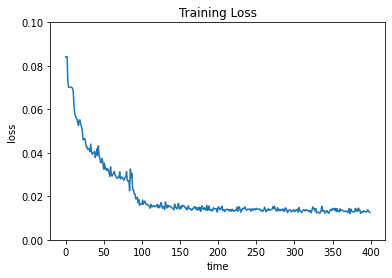

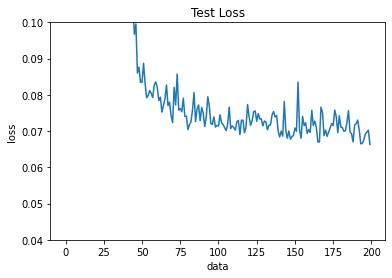

In [30]:
plt.figure()
plt.plot(loss_list)
axes = plt.gca()
plt.title('Training Loss')
plt.xlabel('time')
plt.ylabel('loss')
axes.set_ylim([0,0.1])
plt.show()

plt.figure()
plt.plot(test_loss_list)
axes = plt.gca()
plt.title('Test Loss')
plt.xlabel('data')
plt.ylabel('loss')
axes.set_ylim([0.04,0.1])
plt.show()

In [33]:
n = np.random.randint(0,int(0.2*data_trials))
pred = model(x_test_tensor[n])
print(pred[0])
print(y_test_tensor[n])

tensor([0.7347, 0.9151, 0.6980, 0.3644, 0.7212, 0.1590],
       grad_fn=<SelectBackward>)
tensor([0.7217, 0.9641, 0.6946, 0.5106, 0.7996, 0.0541])
